Sesión 15: Integración de Datos de Múltiples Fuentes
Demo 02: Resolución de Conflictos entre Fuentes

Este demo demuestra técnicas para identificar y resolver inconsistencias
entre diferentes fuentes de datos en operaciones petroleras.

Autor: AdP Meridian Consulting
Fecha: 2025

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# DEMO 02: RESOLUCIÓN DE CONFLICTOS ENTRE FUENTES 

### 1. CREACIÓN DE FUENTES DE DATOS CON CONFLICTOS

In [2]:
# Datos base de producción
np.random.seed(42)
fechas = pd.date_range('2024-01-01', '2024-01-07', freq='D')
pozos = ['PZ001', 'PZ002', 'PZ003']

In [3]:
# FUENTE 1: Sistema SCADA (Automático)
print("✓ Creando datos FUENTE 1 - Sistema SCADA:")
scada_data = []
for fecha in fechas:
    for pozo in pozos:
        # Simulamos lecturas automáticas con pequeños ruidos
        base_prod = {'PZ001': 150, 'PZ002': 90, 'PZ003': 240}[pozo]
        ruido = np.random.normal(0, 5)
        
        scada_data.append({
            'fecha': fecha,
            'pozo_id': pozo,
            'produccion_crudo_bpd': base_prod + ruido,
            'presion_cabeza_psi': 600 + np.random.normal(0, 20),
            'temperatura_c': 65 + np.random.normal(0, 3),
            'fuente': 'SCADA',
            'timestamp_registro': fecha + timedelta(hours=23, minutes=55),
            'calidad_dato': np.random.choice(['Excelente', 'Buena'], p=[0.8, 0.2])
        })

fuente_scada = pd.DataFrame(scada_data)
print(f"  - Registros: {len(fuente_scada)}")
print(f"  - Calidad promedio: {fuente_scada['calidad_dato'].value_counts().to_dict()}")
print()

✓ Creando datos FUENTE 1 - Sistema SCADA:
  - Registros: 21
  - Calidad promedio: {'Excelente': 18, 'Buena': 3}



In [4]:
# FUENTE 2: Reportes Operadores (Manual)
print("✓ Creando datos FUENTE 2 - Reportes Manuales:")
manual_data = []
for fecha in fechas:
    for pozo in pozos:
        # Simulamos reportes manuales con posibles errores humanos
        base_prod = {'PZ001': 150, 'PZ002': 90, 'PZ003': 240}[pozo]
        
        # Introducir errores típicos
        if np.random.random() < 0.1:  # 10% de error de transcripción
            error_factor = np.random.choice([0.1, 10])  # Decimal mal puesto
            produccion = base_prod * error_factor
        else:
            produccion = base_prod + np.random.normal(0, 10)
        
        # Algunos campos pueden estar vacíos
        presion = 600 + np.random.normal(0, 25) if np.random.random() > 0.05 else np.nan
        temperatura = 65 + np.random.normal(0, 5) if np.random.random() > 0.03 else np.nan
        
        manual_data.append({
            'fecha': fecha,
            'pozo_id': pozo,
            'produccion_crudo_bpd': produccion,
            'presion_cabeza_psi': presion,
            'temperatura_c': temperatura,
            'fuente': 'MANUAL',
            'timestamp_registro': fecha + timedelta(hours=np.random.randint(8, 18)),
            'operador': np.random.choice(['Juan P.', 'Maria R.', 'Carlos S.', 'Ana T.'])
        })

fuente_manual = pd.DataFrame(manual_data)
print(f"  - Registros: {len(fuente_manual)}")
print(f"  - Valores nulos en presión: {fuente_manual['presion_cabeza_psi'].isnull().sum()}")
print(f"  - Valores nulos en temperatura: {fuente_manual['temperatura_c'].isnull().sum()}")
print()

✓ Creando datos FUENTE 2 - Reportes Manuales:
  - Registros: 21
  - Valores nulos en presión: 2
  - Valores nulos en temperatura: 1



In [5]:
# FUENTE 3: Sistema de Medición Fiscal (Oficial)
print("✓ Creando datos FUENTE 3 - Medición Fiscal:")
fiscal_data = []
# Solo disponible cada 2 días y no para todos los pozos
for i, fecha in enumerate(fechas[::2]):  # Cada 2 días
    for pozo in pozos[:2]:  # Solo PZ001 y PZ002 tienen medición fiscal
        base_prod = {'PZ001': 150, 'PZ002': 90}[pozo]
        
        fiscal_data.append({
            'fecha': fecha,
            'pozo_id': pozo,
            'produccion_crudo_bpd': base_prod + np.random.normal(0, 2),  # Muy preciso
            'fuente': 'FISCAL',
            'timestamp_registro': fecha + timedelta(hours=12),
            'certificado': True,
            'precision': 'Alta'
        })

fuente_fiscal = pd.DataFrame(fiscal_data)
print(f"  - Registros: {len(fuente_fiscal)}")
print(f"  - Solo pozos: {sorted(fuente_fiscal['pozo_id'].unique())}")
print(f"  - Fechas disponibles: {len(fuente_fiscal['fecha'].unique())}")
print()

✓ Creando datos FUENTE 3 - Medición Fiscal:
  - Registros: 8
  - Solo pozos: ['PZ001', 'PZ002']
  - Fechas disponibles: 4



### 2. IDENTIFICACIÓN DE CONFLICTOS ENTRE FUENTES

In [6]:
# Combinar todas las fuentes para análisis
todas_fuentes = pd.concat([
    fuente_scada[['fecha', 'pozo_id', 'produccion_crudo_bpd', 'fuente']],
    fuente_manual[['fecha', 'pozo_id', 'produccion_crudo_bpd', 'fuente']],
    fuente_fiscal[['fecha', 'pozo_id', 'produccion_crudo_bpd', 'fuente']]
], ignore_index=True)

print("✓ Dataset consolidado de todas las fuentes:")
print(f"  - Total registros: {len(todas_fuentes)}")
print(f"  - Tabla:")
print(todas_fuentes.head())
print(f"  - Fuentes: {sorted(todas_fuentes['fuente'].unique())}")
print()

✓ Dataset consolidado de todas las fuentes:
  - Total registros: 50
  - Tabla:
       fecha pozo_id  produccion_crudo_bpd fuente
0 2024-01-01   PZ001            152.483571  SCADA
1 2024-01-01   PZ002             97.615149  SCADA
2 2024-01-01   PZ003            237.652628  SCADA
3 2024-01-02   PZ001            147.671351  SCADA
4 2024-01-02   PZ002             84.935844  SCADA
  - Fuentes: ['FISCAL', 'MANUAL', 'SCADA']



In [7]:

# Pivot para comparar fuentes lado a lado
pivot_fuentes = todas_fuentes.pivot_table(
    index=['fecha', 'pozo_id'],
    columns='fuente',
    values='produccion_crudo_bpd',
    aggfunc='first'
).reset_index()

print("✓ Comparación lado a lado de fuentes:")
print(pivot_fuentes.head(10))
print()

✓ Comparación lado a lado de fuentes:
fuente      fecha pozo_id      FISCAL      MANUAL       SCADA
0      2024-01-01   PZ001  152.192660  158.219025  152.483571
1      2024-01-01   PZ002   89.329178   70.124311   97.615149
2      2024-01-01   PZ003         NaN  238.947429  237.652628
3      2024-01-02   PZ001         NaN  157.507859  147.671351
4      2024-01-02   PZ002         NaN  900.000000   84.935844
5      2024-01-02   PZ003         NaN  249.148843  232.938481
6      2024-01-03   PZ001  151.270225  160.867270  147.278086
7      2024-01-03   PZ002   87.839598   89.158349   91.878490
8      2024-01-03   PZ003         NaN  247.910319  236.991467
9      2024-01-04   PZ001         NaN  171.904556  144.711445



In [8]:
# Calcular diferencias entre fuentes
pivot_fuentes['diff_scada_manual'] = (
    pivot_fuentes['SCADA'] - pivot_fuentes['MANUAL']
).abs()

pivot_fuentes['diff_scada_fiscal'] = (
    pivot_fuentes['SCADA'] - pivot_fuentes['FISCAL']
).abs()

pivot_fuentes['diff_manual_fiscal'] = (
    pivot_fuentes['MANUAL'] - pivot_fuentes['FISCAL']
).abs()

In [9]:
# Identificar conflictos significativos (diferencia > 10%)
umbral_conflicto = 0.10  # 10%

In [10]:
def identificar_conflicto(row, col1, col2):
    if pd.isna(row[col1]) or pd.isna(row[col2]):
        return False
    diff_porcentual = abs(row[col1] - row[col2]) / max(row[col1], row[col2])
    return diff_porcentual > umbral_conflicto

In [11]:

pivot_fuentes['conflicto_scada_manual'] = pivot_fuentes.apply(
    lambda row: identificar_conflicto(row, 'SCADA', 'MANUAL'), axis=1
)

In [12]:

pivot_fuentes['conflicto_scada_fiscal'] = pivot_fuentes.apply(
    lambda row: identificar_conflicto(row, 'SCADA', 'FISCAL'), axis=1
)

In [13]:
print("✓ Análisis de conflictos:")
conflictos_sm = pivot_fuentes['conflicto_scada_manual'].sum()
conflictos_sf = pivot_fuentes['conflicto_scada_fiscal'].sum()
print(f"  - Conflictos SCADA vs MANUAL: {conflictos_sm}")
print(f"  - Conflictos SCADA vs FISCAL: {conflictos_sf}")

if conflictos_sm > 0:
    print("\n  Ejemplos de conflictos SCADA vs MANUAL:")
    conflictos_ejemplos = pivot_fuentes[pivot_fuentes['conflicto_scada_manual']].head(3)
    for _, row in conflictos_ejemplos.iterrows():
        pct_diff = abs(row['SCADA'] - row['MANUAL']) / max(row['SCADA'], row['MANUAL']) * 100
        print(f"    {row['fecha'].strftime('%Y-%m-%d')} {row['pozo_id']}: "
              f"SCADA={row['SCADA']:.1f}, MANUAL={row['MANUAL']:.1f} "
              f"(diff={pct_diff:.1f}%)")
print()

✓ Análisis de conflictos:
  - Conflictos SCADA vs MANUAL: 6
  - Conflictos SCADA vs FISCAL: 0

  Ejemplos de conflictos SCADA vs MANUAL:
    2024-01-01 PZ002: SCADA=97.6, MANUAL=70.1 (diff=28.2%)
    2024-01-02 PZ002: SCADA=84.9, MANUAL=900.0 (diff=90.6%)
    2024-01-04 PZ001: SCADA=144.7, MANUAL=171.9 (diff=15.8%)



### 3. ESTRATEGIAS DE RESOLUCIÓN DE CONFLICTOS

#### ESTRATEGIA 1: Jerarquía de Fuentes

In [14]:
jerarquia = {'FISCAL': 1, 'SCADA': 2, 'MANUAL': 3}  # 1 = máxima prioridad

In [15]:
def resolver_por_jerarquia(row):
    """Selecciona el valor de la fuente con mayor prioridad disponible."""
    for fuente in sorted(jerarquia.keys(), key=lambda x: jerarquia[x]):
        if not pd.isna(row[fuente]):
            return row[fuente], fuente
    return np.nan, 'NINGUNA'

In [16]:
pivot_fuentes[['valor_jerarquia', 'fuente_seleccionada']] = pivot_fuentes.apply(
    resolver_por_jerarquia, axis=1, result_type='expand'
)

In [17]:
print(f"  - Registros resueltos: {pivot_fuentes['fuente_seleccionada'].notna().sum()}")
fuente_counts = pivot_fuentes['fuente_seleccionada'].value_counts()
print(f"  - Distribución por fuente: {fuente_counts.to_dict()}")
print(pivot_fuentes.head(5))

  - Registros resueltos: 21
  - Distribución por fuente: {'SCADA': 13, 'FISCAL': 8}
fuente      fecha pozo_id      FISCAL      MANUAL       SCADA  \
0      2024-01-01   PZ001  152.192660  158.219025  152.483571   
1      2024-01-01   PZ002   89.329178   70.124311   97.615149   
2      2024-01-01   PZ003         NaN  238.947429  237.652628   
3      2024-01-02   PZ001         NaN  157.507859  147.671351   
4      2024-01-02   PZ002         NaN  900.000000   84.935844   

fuente  diff_scada_manual  diff_scada_fiscal  diff_manual_fiscal  \
0                5.735454           0.290911            6.026365   
1               27.490838           8.285971           19.204867   
2                1.294801                NaN                 NaN   
3                9.836508                NaN                 NaN   
4              815.064156                NaN                 NaN   

fuente  conflicto_scada_manual  conflicto_scada_fiscal  valor_jerarquia  \
0                        False           

#### Estrategia 2: Promedio ponderado

In [18]:
pesos = {'FISCAL': 0.6, 'SCADA': 0.3, 'MANUAL': 0.1}

In [19]:
def resolver_por_promedio_ponderado(row):
    """Calcula promedio ponderado de fuentes disponibles."""
    valores = []
    pesos_disponibles = []
    
    for fuente, peso in pesos.items():
        if not pd.isna(row[fuente]):
            valores.append(row[fuente])
            pesos_disponibles.append(peso)
    
    if valores:
        # Normalizar pesos
        suma_pesos = sum(pesos_disponibles)
        pesos_norm = [p/suma_pesos for p in pesos_disponibles]
        return sum(v*p for v, p in zip(valores, pesos_norm))
    return np.nan

In [20]:
pivot_fuentes['valor_promedio_ponderado'] = pivot_fuentes.apply(
    resolver_por_promedio_ponderado, axis=1
)

In [21]:

print(f"  - Registros con promedio calculado: {pivot_fuentes['valor_promedio_ponderado'].notna().sum()}")
print(pivot_fuentes.head(5))

  - Registros con promedio calculado: 21
fuente      fecha pozo_id      FISCAL      MANUAL       SCADA  \
0      2024-01-01   PZ001  152.192660  158.219025  152.483571   
1      2024-01-01   PZ002   89.329178   70.124311   97.615149   
2      2024-01-01   PZ003         NaN  238.947429  237.652628   
3      2024-01-02   PZ001         NaN  157.507859  147.671351   
4      2024-01-02   PZ002         NaN  900.000000   84.935844   

fuente  diff_scada_manual  diff_scada_fiscal  diff_manual_fiscal  \
0                5.735454           0.290911            6.026365   
1               27.490838           8.285971           19.204867   
2                1.294801                NaN                 NaN   
3                9.836508                NaN                 NaN   
4              815.064156                NaN                 NaN   

fuente  conflicto_scada_manual  conflicto_scada_fiscal  valor_jerarquia  \
0                        False                   False       152.192660   
1        

#### Estrategia 3: Validación cruzada con umbrales

In [22]:
def resolver_por_validacion_cruzada(row):
    """Usa consenso entre fuentes o rechaza outliers."""
    valores_disponibles = []
    fuentes_disponibles = []
    
    for fuente in ['FISCAL', 'SCADA', 'MANUAL']:
        if not pd.isna(row[fuente]):
            valores_disponibles.append(row[fuente])
            fuentes_disponibles.append(fuente)
    
    if len(valores_disponibles) < 2:
        return valores_disponibles[0] if valores_disponibles else np.nan, fuentes_disponibles[0] if fuentes_disponibles else 'NINGUNA'
    
    # Si tenemos múltiples valores, verificar consenso
    promedio = np.mean(valores_disponibles)
    valores_validos = []
    fuentes_validas = []
    
    # Umbral de desviación del 15%
    umbral = 0.15
    for valor, fuente in zip(valores_disponibles, fuentes_disponibles):
        desviacion = abs(valor - promedio) / promedio
        if desviacion <= umbral:
            valores_validos.append(valor)
            fuentes_validas.append(fuente)
    
    if valores_validos:
        # Usar promedio de valores válidos
        return np.mean(valores_validos), '+'.join(fuentes_validas)
    else:
        # Si no hay consenso, usar fuente más confiable
        return row['FISCAL'] if not pd.isna(row['FISCAL']) else row['SCADA'], 'FISCAL' if not pd.isna(row['FISCAL']) else 'SCADA'


In [23]:
pivot_fuentes[['valor_validacion_cruzada', 'fuentes_validacion']] = pivot_fuentes.apply(
    resolver_por_validacion_cruzada, axis=1, result_type='expand'
)

In [32]:

print(f"  - Registros validados: {pivot_fuentes['fuentes_validacion'].notna().sum()}")
validacion_counts = pivot_fuentes['fuentes_validacion'].value_counts()
print(f"  - Distribución de fuentes usadas: {validacion_counts.head().to_dict()}")
print(pivot_fuentes.head(3))

  - Registros validados: 21
  - Distribución de fuentes usadas: {'SCADA+MANUAL': 12, 'FISCAL+SCADA+MANUAL': 7, 'FISCAL+SCADA': 1, 'SCADA': 1}
fuente      fecha pozo_id      FISCAL      MANUAL       SCADA  \
0      2024-01-01   PZ001  152.192660  158.219025  152.483571   
1      2024-01-01   PZ002   89.329178   70.124311   97.615149   
2      2024-01-01   PZ003         NaN  238.947429  237.652628   

fuente  diff_scada_manual  diff_scada_fiscal  diff_manual_fiscal  \
0                5.735454           0.290911            6.026365   
1               27.490838           8.285971           19.204867   
2                1.294801                NaN                 NaN   

fuente  conflicto_scada_manual  conflicto_scada_fiscal  valor_jerarquia  \
0                        False                   False       152.192660   
1                         True                   False        89.329178   
2                        False                   False       237.652628   

fuente fuente_seleccion

#### 4. COMPARACIÓN DE ESTRATEGIAS

In [33]:
# Calcular métricas de comparación
estrategias = {
    'Jerarquía': 'valor_jerarquia',
    'Promedio Ponderado': 'valor_promedio_ponderado', 
    'Validación Cruzada': 'valor_validacion_cruzada'
}


In [34]:
print("✓ Estadísticas por estrategia:")
for nombre, columna in estrategias.items():
    datos_validos = pivot_fuentes[columna].dropna()
    print(f"\n  {nombre}:")
    print(f"    - Registros completos: {len(datos_validos)}")
    print(f"    - Promedio: {datos_validos.mean():.2f}")
    print(f"    - Desviación estándar: {datos_validos.std():.2f}")
    print(f"    - Rango: {datos_validos.min():.2f} - {datos_validos.max():.2f}")

# Calcular diferencias entre estrategias
print("\n✓ Diferencias entre estrategias:")
diff_j_p = (pivot_fuentes['valor_jerarquia'] - pivot_fuentes['valor_promedio_ponderado']).abs().mean()
diff_j_v = (pivot_fuentes['valor_jerarquia'] - pivot_fuentes['valor_validacion_cruzada']).abs().mean()
diff_p_v = (pivot_fuentes['valor_promedio_ponderado'] - pivot_fuentes['valor_validacion_cruzada']).abs().mean()

print(f"  - Jerarquía vs Promedio: {diff_j_p:.2f} bpd promedio")
print(f"  - Jerarquía vs Validación: {diff_j_v:.2f} bpd promedio")
print(f"  - Promedio vs Validación: {diff_p_v:.2f} bpd promedio")
print()

✓ Estadísticas por estrategia:

  Jerarquía:
    - Registros completos: 21
    - Promedio: 158.77
    - Desviación estándar: 63.78
    - Rango: 84.94 - 244.88

  Promedio Ponderado:
    - Registros completos: 21
    - Promedio: 169.59
    - Desviación estándar: 67.37
    - Rango: 84.45 - 288.70

  Validación Cruzada:
    - Registros completos: 21
    - Promedio: 161.37
    - Desviación estándar: 64.02
    - Rango: 83.10 - 246.04

✓ Diferencias entre estrategias:
  - Jerarquía vs Promedio: 11.58 bpd promedio
  - Jerarquía vs Validación: 4.07 bpd promedio
  - Promedio vs Validación: 11.94 bpd promedio



#### 5. IMPLEMENTACIÓN DE REGLAS AUTOMÁTICAS

In [37]:
def resolver_automatico(row):
    """
    Implementa lógica automática para resolver conflictos:
    1. Si existe FISCAL, usarlo (máxima confiabilidad)
    2. Si SCADA y MANUAL coinciden (±10%), usar promedio
    3. Si difieren significativamente, validar contra patrones históricos
    4. En caso de duda, usar SCADA (más frecuente y consistente)
    """
    
    # Regla 1: FISCAL tiene prioridad absoluta
    if not pd.isna(row['FISCAL']):
        return row['FISCAL'], 'FISCAL_DIRECTO'
    
    # Regla 2: Consenso SCADA-MANUAL
    if not pd.isna(row['SCADA']) and not pd.isna(row['MANUAL']):
        diff_pct = abs(row['SCADA'] - row['MANUAL']) / max(row['SCADA'], row['MANUAL'])
        if diff_pct <= 0.10:  # Diferencia menor al 10%
            return (row['SCADA'] + row['MANUAL']) / 2, 'CONSENSO_SM'
        else:
            # Validar contra rango esperado del pozo
            rangos_esperados = {
                'PZ001': (140, 160),
                'PZ002': (80, 100),
                'PZ003': (220, 250)
            }
            rango = rangos_esperados.get(row['pozo_id'], (0, 1000))
            
            scada_valido = rango[0] <= row['SCADA'] <= rango[1]
            manual_valido = rango[0] <= row['MANUAL'] <= rango[1]
            
            if scada_valido and not manual_valido:
                return row['SCADA'], 'SCADA_VALIDADO'
            elif manual_valido and not scada_valido:
                return row['MANUAL'], 'MANUAL_VALIDADO'
            else:
                # Ambos válidos o ambos inválidos: preferir SCADA
                return row['SCADA'], 'SCADA_PREFERENCIA'
    
    # Regla 3: Solo una fuente disponible
    if not pd.isna(row['SCADA']):
        return row['SCADA'], 'SCADA_UNICO'
    elif not pd.isna(row['MANUAL']):
        return row['MANUAL'], 'MANUAL_UNICO'
    
    return np.nan, 'SIN_DATOS'

In [38]:
pivot_fuentes[['valor_automatico', 'metodo_automatico']] = pivot_fuentes.apply(
    resolver_automatico, axis=1, result_type='expand'
)

In [39]:

print("✓ Resolución automática completada:")
metodo_counts = pivot_fuentes['metodo_automatico'].value_counts()
for metodo, count in metodo_counts.items():
    print(f"  - {metodo}: {count} casos")
print()

✓ Resolución automática completada:
  - CONSENSO_SM: 10 casos
  - FISCAL_DIRECTO: 8 casos
  - SCADA_VALIDADO: 3 casos



#### 6. VISUALIZACIÓN DE RESULTADOS

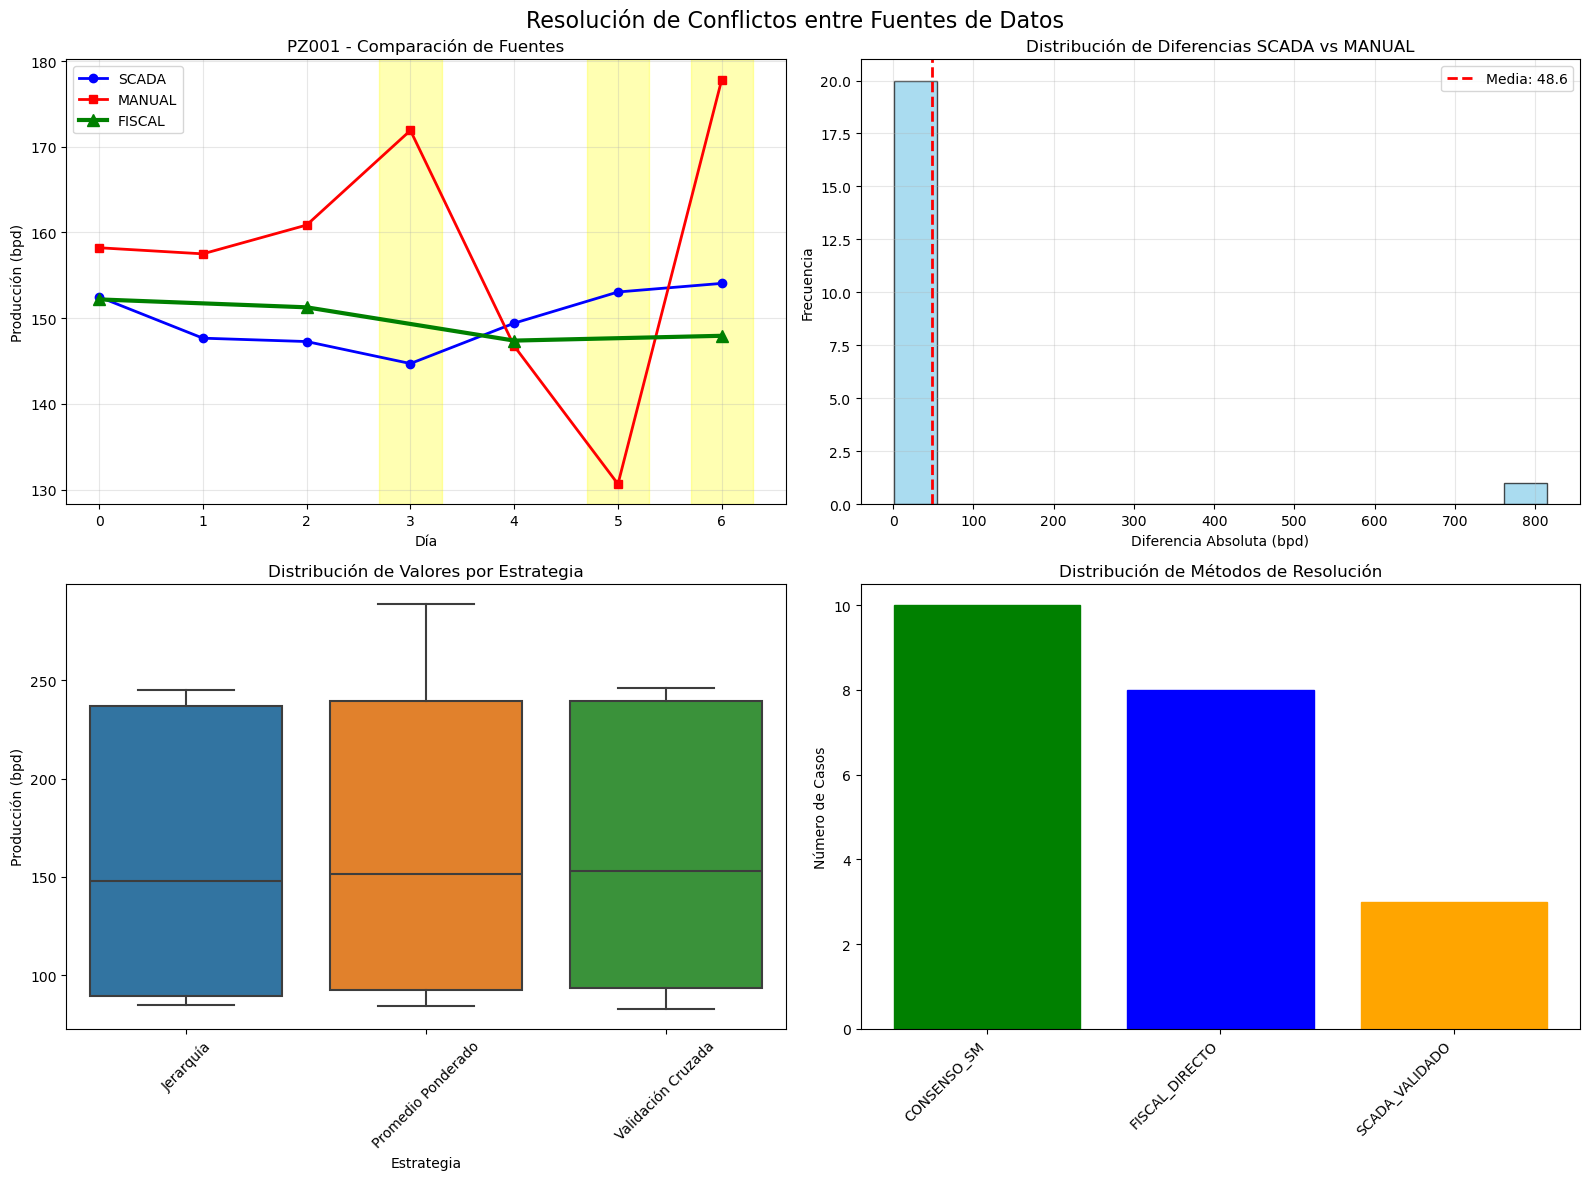

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Resolución de Conflictos entre Fuentes de Datos', fontsize=16, y=0.98)

# Gráfico 1: Comparación de fuentes para PZ001
pz001_data = pivot_fuentes[pivot_fuentes['pozo_id'] == 'PZ001'].copy()
ax1 = axes[0, 0]
x_pos = range(len(pz001_data))

if not pz001_data.empty:
    ax1.plot(x_pos, pz001_data['SCADA'], 'b-o', label='SCADA', linewidth=2)
    ax1.plot(x_pos, pz001_data['MANUAL'], 'r-s', label='MANUAL', linewidth=2)
    fiscal_data = pz001_data['FISCAL'].dropna()
    if not fiscal_data.empty:
        fiscal_x = [i for i, v in enumerate(pz001_data['FISCAL']) if not pd.isna(v)]
        ax1.plot(fiscal_x, fiscal_data, 'g-^', label='FISCAL', linewidth=3, markersize=8)
    
    ax1.set_xlabel('Día')
    ax1.set_ylabel('Producción (bpd)')
    ax1.set_title('PZ001 - Comparación de Fuentes')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Marcar conflictos
    conflictos = pz001_data['conflicto_scada_manual']
    for i, conflicto in enumerate(conflictos):
        if conflicto:
            ax1.axvspan(i-0.3, i+0.3, alpha=0.3, color='yellow', label='Conflicto' if i == conflictos.idxmax() else "")

# Gráfico 2: Distribución de diferencias
ax2 = axes[0, 1]
diferencias = pivot_fuentes['diff_scada_manual'].dropna()
if not diferencias.empty:
    ax2.hist(diferencias, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(diferencias.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {diferencias.mean():.1f}')
    ax2.set_xlabel('Diferencia Absoluta (bpd)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribución de Diferencias SCADA vs MANUAL')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# Gráfico 3: Comparación de estrategias
ax3 = axes[1, 0]
estrategias_data = []
for nombre, columna in estrategias.items():
    valores = pivot_fuentes[columna].dropna()
    if not valores.empty:
        estrategias_data.extend([(nombre, v) for v in valores])

if estrategias_data:
    estrategias_df = pd.DataFrame(estrategias_data, columns=['Estrategia', 'Valor'])
    sns.boxplot(data=estrategias_df, x='Estrategia', y='Valor', ax=ax3)
    ax3.set_title('Distribución de Valores por Estrategia')
    ax3.set_ylabel('Producción (bpd)')
    ax3.tick_params(axis='x', rotation=45)

# Gráfico 4: Métodos de resolución automática
ax4 = axes[1, 1]
metodo_counts = pivot_fuentes['metodo_automatico'].value_counts()
if not metodo_counts.empty:
    bars = ax4.bar(range(len(metodo_counts)), metodo_counts.values)
    ax4.set_xticks(range(len(metodo_counts)))
    ax4.set_xticklabels(metodo_counts.index, rotation=45, ha='right')
    ax4.set_ylabel('Número de Casos')
    ax4.set_title('Distribución de Métodos de Resolución')
    
    # Colorear barras según el tipo de método
    colors = ['green', 'blue', 'orange', 'red', 'purple', 'brown', 'gray']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

plt.tight_layout()

In [41]:
plt.savefig('../datos/demo_02_conflictos.png', dpi=300, bbox_inches='tight')
print("✓ Gráficos guardados en: ../datos/demo_02_conflictos.png")


✓ Gráficos guardados en: ../datos/demo_02_conflictos.png


<Figure size 640x480 with 0 Axes>

#### 7. EXPORTACIÓN DE RESULTADOS

In [42]:
# Dataset final con resolución automática
dataset_final = pivot_fuentes[['fecha', 'pozo_id', 'valor_automatico', 'metodo_automatico']].copy()
dataset_final.rename(columns={
    'valor_automatico': 'produccion_crudo_bpd',
    'metodo_automatico': 'metodo_resolucion'
}, inplace=True)


In [43]:
# Agregar métricas de calidad
dataset_final['numero_fuentes_disponibles'] = (
    pivot_fuentes[['SCADA', 'MANUAL', 'FISCAL']].notna().sum(axis=1)
)

In [44]:
dataset_final['confiabilidad'] = dataset_final['metodo_resolucion'].map({
    'FISCAL_DIRECTO': 'Muy Alta',
    'CONSENSO_SM': 'Alta',
    'SCADA_VALIDADO': 'Alta',
    'MANUAL_VALIDADO': 'Media',
    'SCADA_PREFERENCIA': 'Media',
    'SCADA_UNICO': 'Media',
    'MANUAL_UNICO': 'Baja',
    'SIN_DATOS': 'Sin Datos'
})

In [48]:
(dataset_final.head())

fuente,fecha,pozo_id,produccion_crudo_bpd,metodo_resolucion,numero_fuentes_disponibles,confiabilidad
0,2024-01-01,PZ001,152.192660,FISCAL_DIRECTO,3,Muy Alta
1,2024-01-01,PZ002,89.329178,FISCAL_DIRECTO,3,Muy Alta
2,2024-01-01,PZ003,238.300028,CONSENSO_SM,2,Alta
3,2024-01-02,PZ001,152.589605,CONSENSO_SM,2,Alta
4,2024-01-02,PZ002,84.935844,SCADA_VALIDADO,2,Alta


In [ ]:
dataset_final.to_csv('../datos/produccion_conflictos_resueltos.csv', index=False)
print("✓ Dataset final guardado: ../datos/produccion_conflictos_resueltos.csv")


In [47]:
# Reporte de conflictos detectados
reporte_conflictos = pivot_fuentes[
    pivot_fuentes['conflicto_scada_manual'] | pivot_fuentes['conflicto_scada_fiscal']
].copy()
reporte_conflictos.head()

fuente,fecha,pozo_id,FISCAL,MANUAL,SCADA,diff_scada_manual,diff_scada_fiscal,diff_manual_fiscal,conflicto_scada_manual,conflicto_scada_fiscal,valor_jerarquia,fuente_seleccionada,valor_promedio_ponderado,valor_validacion_cruzada,fuentes_validacion,valor_automatico,metodo_automatico
1,2024-01-01,PZ002,89.329178,70.124311,97.615149,27.490838,8.285971,19.204867,True,False,89.329178,FISCAL,89.894483,93.472164,FISCAL+SCADA,89.329178,FISCAL_DIRECTO
4,2024-01-02,PZ002,NaN,900.000000,84.935844,815.064156,NaN,NaN,True,False,84.935844,SCADA,288.701883,84.935844,SCADA,84.935844,SCADA_VALIDADO
9,2024-01-04,PZ001,NaN,171.904556,144.711445,27.193111,NaN,NaN,True,False,144.711445,SCADA,151.509723,158.308001,SCADA+MANUAL,144.711445,SCADA_VALIDADO
13,2024-01-05,PZ002,88.498476,101.907273,86.400779,15.506494,2.097697,13.408796,True,False,88.498476,FISCAL,89.210047,92.268843,FISCAL+SCADA+MANUAL,88.498476,FISCAL_DIRECTO
15,2024-01-06,PZ001,NaN,130.654298,153.058381,22.404083,NaN,NaN,True,False,153.058381,SCADA,147.457361,141.856340,SCADA+MANUAL,153.058381,SCADA_VALIDADO


In [ ]:

if not reporte_conflictos.empty:
    reporte_conflictos.to_csv('../datos/reporte_conflictos_detectados.csv', index=False)
    print("✓ Reporte de conflictos guardado: ../datos/reporte_conflictos_detectados.csv")
print()

#### 8. RESUMEN EJECUTIVO

In [50]:
print("8. RESUMEN EJECUTIVO")
print("-"*50)
total_registros = len(pivot_fuentes)
registros_con_conflictos = (pivot_fuentes['conflicto_scada_manual'] | 
                           pivot_fuentes['conflicto_scada_fiscal']).sum()

print(f"✓ Resumen de la resolución de conflictos:")
print(f"  • Total de registros procesados: {total_registros}")
print(f"  • Registros con conflictos detectados: {registros_con_conflictos} ({registros_con_conflictos/total_registros*100:.1f}%)")
print(f"  • Registros resueltos automáticamente: {dataset_final['produccion_crudo_bpd'].notna().sum()}")
print()

print("✓ Distribución de confiabilidad final:")
conf_counts = dataset_final['confiabilidad'].value_counts()
for nivel, count in conf_counts.items():
    print(f"  • {nivel}: {count} registros ({count/len(dataset_final)*100:.1f}%)")
print()

print("✓ Técnicas implementadas:")
print("  • Jerarquía de fuentes basada en confiabilidad")
print("  • Promedio ponderado con pesos ajustables")
print("  • Validación cruzada con umbrales de consenso")
print("  • Validación contra rangos históricos esperados")
print("  • Resolución automática con reglas de negocio")
print()

8. RESUMEN EJECUTIVO
--------------------------------------------------
✓ Resumen de la resolución de conflictos:
  • Total de registros procesados: 21
  • Registros con conflictos detectados: 6 (28.6%)
  • Registros resueltos automáticamente: 21

✓ Distribución de confiabilidad final:
  • Alta: 13 registros (61.9%)
  • Muy Alta: 8 registros (38.1%)

✓ Técnicas implementadas:
  • Jerarquía de fuentes basada en confiabilidad
  • Promedio ponderado con pesos ajustables
  • Validación cruzada con umbrales de consenso
  • Validación contra rangos históricos esperados
  • Resolución automática con reglas de negocio

